In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.metrics import mean_squared_error


# loading in the dataframes -> EF stands for 'engineered features' which were created this week 
EF_ice_thickness = pd.read_csv('../data/AIS_data/EF_ice_thickness.csv')
EF_ice_velocity = pd.read_csv('../data/AIS_data/EF_ice_velocity.csv')

#shifting the columns so the target is the one furthest to the right 
EF_ice_thickness = EF_ice_thickness[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_thickness']]

EF_ice_velocity = EF_ice_velocity[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_velocity']]


#removing any rows with thickness 0 or velocity NaN
EF_ice_thickness = EF_ice_thickness[EF_ice_thickness['ice_thickness']!=0]
EF_ice_velocity = EF_ice_velocity.dropna()


EF_ice_velocity.head()



,x-axis,y-axis,precipitation,air_temp,ocean_temp,dist,precip_roll,air_roll,ocean_roll,ice_velocity
431,-243200,2067200,404.280640,251.581512,272.344940,2.081457e+06,304.963210,254.291912,272.542176,4.782738
432,-121600,2067200,527.547485,250.521286,272.534760,2.070773e+06,297.774318,252.450821,272.642754,0.017201
433,0,2067200,352.272278,249.629227,272.597290,2.067200e+06,280.700286,250.954194,272.738224,590.315247
434,121600,2067200,261.181396,251.433914,273.296387,2.070773e+06,273.509615,249.935943,272.838369,45.191998
435,243200,2067200,358.309296,250.613602,273.666199,2.081457e+06,266.585832,249.670710,272.942012,17.135721


In [61]:
def scale (df):
    """uses the formula scaled val = (val-column minimum)/(column maximum - column minimum)"""
    scaled_df = df.copy()
    # for column in df.columns[:-1]  -> use this line instead for not having a scaled target 
    for column in scaled_df.columns:
        min_value = scaled_df[column].min()
        max_value = scaled_df[column].max()
        scaled_df[column] = (scaled_df[column] - min_value) / (max_value - min_value)
            
    return scaled_df

def scale_ice_mask_cols(df):
    """uses the formula scaled val = (val-column minimum)/(column maximum - column minimum)"""
    scaled_df = df.copy()
    # for column in df.columns[:-1]  -> use this line instead for not having a scaled target 
    columns = ['x-axis', 'y-axis', 'precipitation', 'air_temp', 'ocean_temp', 'dist', 'air_roll', 
              'ocean_roll', 'precip_roll']
    for column in columns:
        min_value = scaled_df[column].min()
        max_value = scaled_df[column].max()
        scaled_df[column] = (scaled_df[column] - min_value) / (max_value - min_value)
            
    return scaled_df

def unscale_rmse(scaled_rmse, target_name, original_df):
    target_min = original_df[target_name].min()
    target_max = original_df[target_name].max()

    return scaled_rmse * (target_max - target_min)


In [62]:
#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doRandomForest(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = RandomForestRegressor(random_state=randomState)
        
        model.fit(X_train, y_train)
        
        #, max_features = 2
        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))
        importances.append(model.feature_importances_)
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_importances, std_importances = np.mean(importances, axis=0), np.std(importances, axis=0)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Importances:", avg_importances)
    print("Importances Std Dev:", std_importances)
    print(f"\n\n Train-Test (Difference): {avg_train_score - avg_test_score :.4f}")


    return avg_importances, std_importances

In [63]:
seed = 101
EF_ice_thickness_scaled = scale(EF_ice_thickness)
print("+++++++++++++ ICE THICKNESS BELOW +++++++++++++++++++")
IT_importances, IT_std_importances = doRandomForest(EF_ice_thickness_scaled, seed, 30, 'ice_thickness', EF_ice_thickness)

print('\n\n')
print("+++++++++++++ ICE Velocity BELOW +++++++++++++++++++")
EF_ice_velocity_scaled = scale(EF_ice_velocity)
IV_importances, IV_std_importances = doRandomForest(EF_ice_velocity_scaled, seed, 30, 'ice_velocity', EF_ice_velocity)

+++++++++++++ ICE THICKNESS BELOW +++++++++++++++++++
Training Average Score: 0.9780, Std Dev: 0.0009
Training Average RMSE: 159.16, Std Dev: 3.37


Test Average Score: 0.8447, Std Dev: 0.0166
Test Average RMSE: 424.08, Std Dev: 21.02


Average Importances: [0.05792263 0.05104243 0.02519763 0.15540522 0.03923555 0.04720431
 0.03412923 0.55836092 0.03150208]
Importances Std Dev: [0.00772614 0.00359219 0.0024045  0.06131962 0.00806638 0.00490357
 0.00641083 0.06225303 0.00327453]


 Train-Test (Difference): 0.1333



+++++++++++++ ICE Velocity BELOW +++++++++++++++++++
Training Average Score: 0.8761, Std Dev: 0.0125
Training Average RMSE: 106.87, Std Dev: 7.53


Test Average Score: 0.0973, Std Dev: 0.1930
Test Average RMSE: 281.92, Std Dev: 45.74


Average Importances: [0.039544   0.08180195 0.15468706 0.30809907 0.0755312  0.05597543
 0.08116542 0.10257382 0.10062205]
Importances Std Dev: [0.00750566 0.02314813 0.04539371 0.05837442 0.01536738 0.01128811
 0.02156901 0.02589676 0.0247057

In [79]:
def doRandomForestWithTuning(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []
    best_params = []
    
    X = preprocessed_df.iloc[:, :-1]
    y = preprocessed_df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    for i in range(n_runs):
        randomState = i * seed

        # Define the model
        rf = RandomForestRegressor(random_state=randomState)

        # Set up the grid of parameters to search
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': [1,2,3,4,5], 
            'max_leaf_nodes':[60, 90, 120]
        }

        # Set up the grid search
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

        # Fit the grid search to the data
        grid_search.fit(X_train, y_train)

        # Store best parameters
        #best_params.append(grid_search.best_params_)
        best_params.append(grid_search.cv_results_['params'][grid_search.best_index_])

    print("Best Parameters per Run:", best_params)

    return best_params, param_grid

In [80]:
seed = 101
n_runs = 30
EF_ice_thickness_scaled = scale(EF_ice_thickness)
print("+++++++++++++ ICE THICKNESS BELOW +++++++++++++++++++")
IT_best_params, param_grid = doRandomForestWithTuning(EF_ice_thickness_scaled, seed, n_runs, 'ice_thickness', EF_ice_thickness)

print('\n\n')
print("+++++++++++++ ICE VELOCITY BELOW +++++++++++++++++++")
EF_ice_velocity_scaled = scale(EF_ice_velocity)
IV_best_params, param_grid = doRandomForestWithTuning(EF_ice_velocity_scaled, seed, n_runs, 'ice_velocity', EF_ice_velocity)

+++++++++++++ ICE THICKNESS BELOW +++++++++++++++++++
Fitting 3 folds for each of 1215 candidates, totalling 3645 fits
Fitting 3 folds for each of 1215 candidates, totalling 3645 fits
Fitting 3 folds for each of 1215 candidates, totalling 3645 fits
Fitting 3 folds for each of 1215 candidates, totalling 3645 fits
Fitting 3 folds for each of 1215 candidates, totalling 3645 fits
Fitting 3 folds for each of 1215 candidates, totalling 3645 fits
Fitting 3 folds for each of 1215 candidates, totalling 3645 fits
Fitting 3 folds for each of 1215 candidates, totalling 3645 fits
Fitting 3 folds for each of 1215 candidates, totalling 3645 fits
Fitting 3 folds for each of 1215 candidates, totalling 3645 fits
Fitting 3 folds for each of 1215 candidates, totalling 3645 fits
Fitting 3 folds for each of 1215 candidates, totalling 3645 fits
Fitting 3 folds for each of 1215 candidates, totalling 3645 fits
Fitting 3 folds for each of 1215 candidates, totalling 3645 fits
Fitting 3 folds for each of 1215 can

In [81]:
import matplotlib.pyplot as plt

def visualize_parameter_distribution_no_grid(param_dict, param_grid, n_runs):
    # Convert 'None' to string 'None' for 'max_depth'
    for d in param_dict:
        if 'max_depth' in d and d['max_depth'] is None:
            d['max_depth'] = 'None'
    
    # Convert the dictionary to a DataFrame for easier manipulation
    df = pd.DataFrame(param_dict)

    # Loop through each parameter in the grid and create separate bar charts
    for param, values in param_grid.items():
        
        if param == "max_depth":
            values = ['None' if v is None else v for v in values]
            
        
        # Count the occurrences of each parameter value in the dictionary
        param_counts = df[param].value_counts().reindex(values, fill_value=0)
        print("param counts")
        print(param_counts)
        # Plot the bar chart for the parameter
        plt.figure(figsize=(8, 4))
        plt.bar(param_counts.index.astype(str), param_counts.values, color='skyblue')
        plt.title(f'Distribution of {param}')
        plt.xlabel(param)
        plt.ylabel('Count')
        plt.ylim(0, n_runs)  # Set y-axis limit to n_runs
        plt.show()


param counts
n_estimators
100     6
200     8
300    16
Name: count, dtype: int64


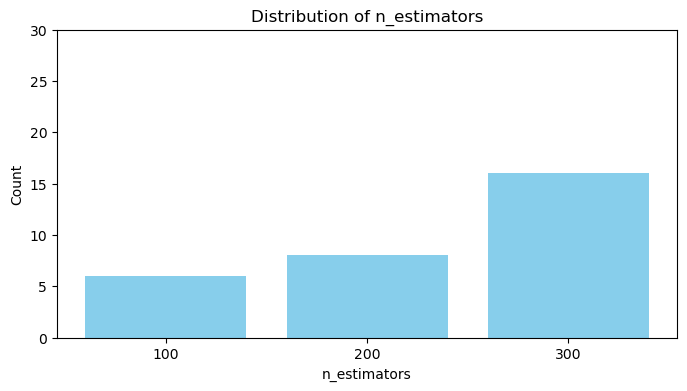

param counts
max_depth
None    22
10       8
20       0
Name: count, dtype: int64


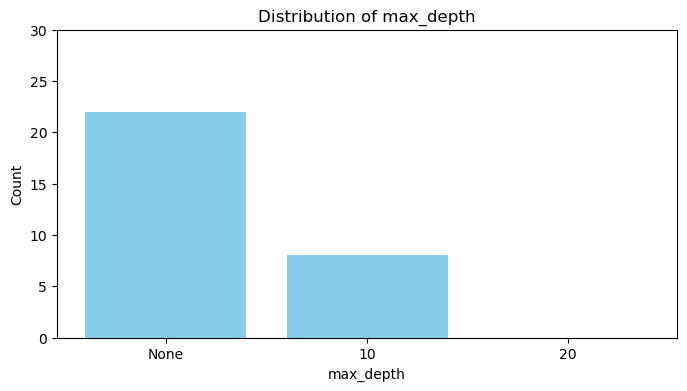

param counts
min_samples_split
2     29
5      1
10     0
Name: count, dtype: int64


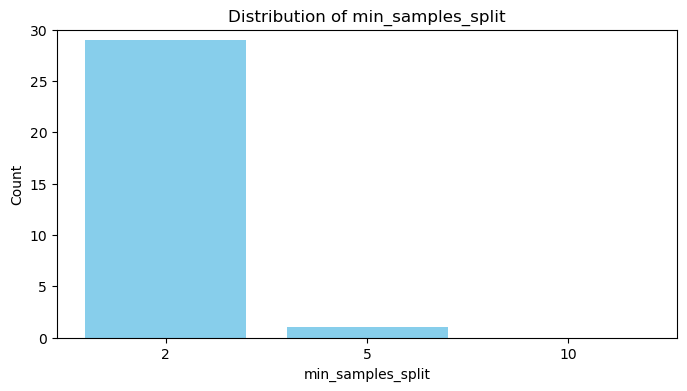

param counts
min_samples_leaf
1    28
2     2
4     0
Name: count, dtype: int64


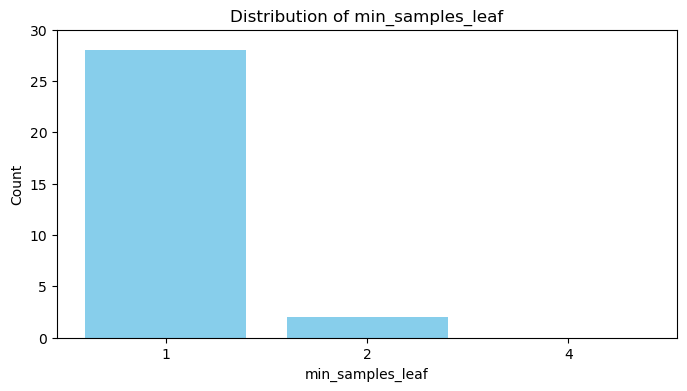

param counts
max_features
1     0
2     1
3     4
4    12
5    13
Name: count, dtype: int64


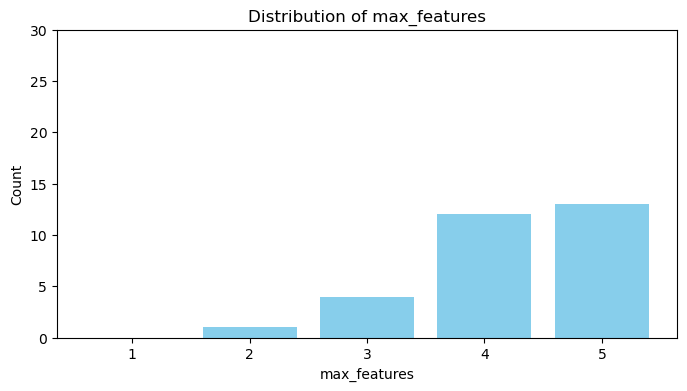

param counts
max_leaf_nodes
60      0
90      1
120    29
Name: count, dtype: int64


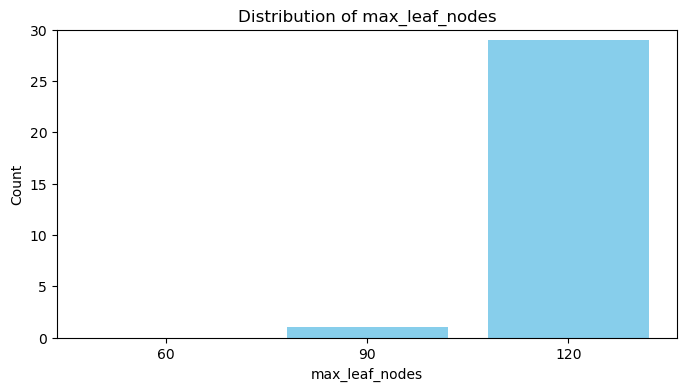

In [82]:
# Call the function with the 'n_runs' parameter
n_runs=30
visualize_parameter_distribution_no_grid(IT_best_params, param_grid, n_runs)

param counts
n_estimators
100    16
200     6
300     8
Name: count, dtype: int64


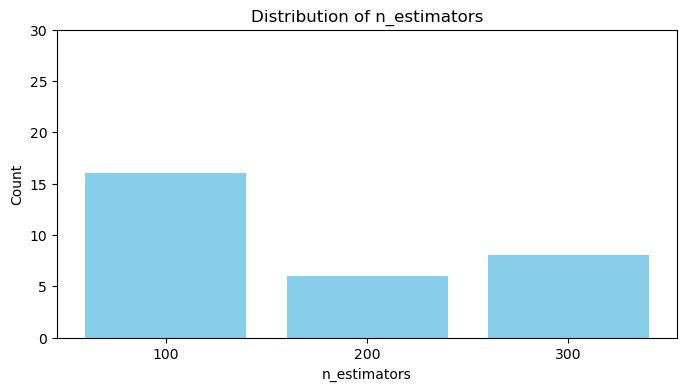

param counts
max_depth
None    10
10       5
20      15
Name: count, dtype: int64


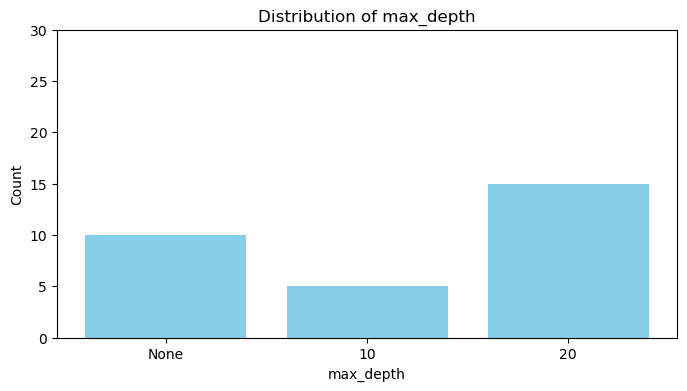

param counts
min_samples_split
2     22
5      8
10     0
Name: count, dtype: int64


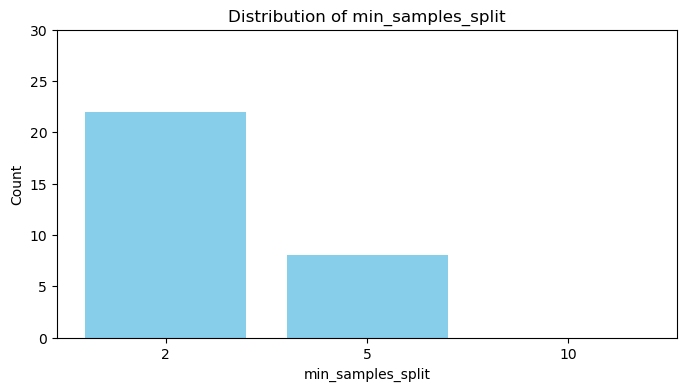

param counts
min_samples_leaf
1    13
2    17
4     0
Name: count, dtype: int64


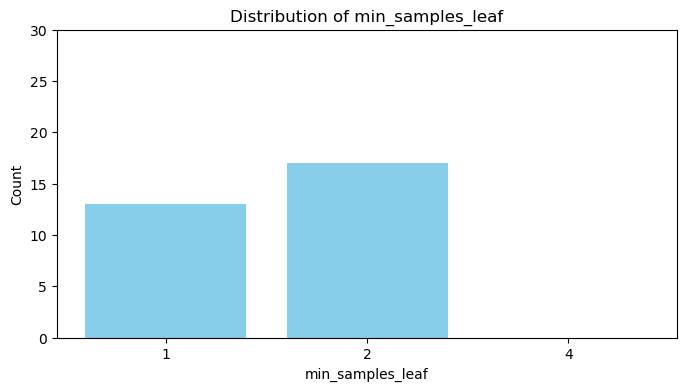

param counts
max_features
1    10
2    12
3     5
4     3
5     0
Name: count, dtype: int64


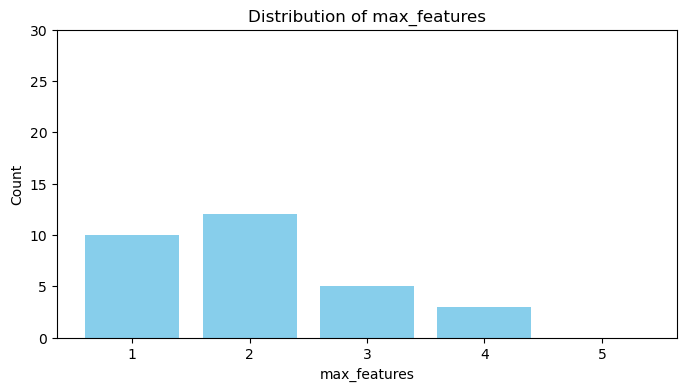

param counts
max_leaf_nodes
60      1
90      4
120    25
Name: count, dtype: int64


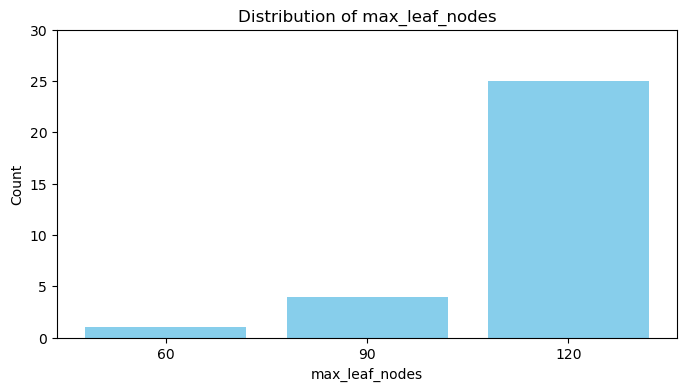

In [83]:
# Call the function with the 'n_runs' parameter
n_runs=30
visualize_parameter_distribution_no_grid(IV_best_params, param_grid, n_runs)

In [ ]:
ice thickness: 
[{'max_depth': None, 'max_features': 4, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}, {'max_depth': None, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, {'max_depth': 10, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, {'max_depth': 10, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}, {'max_depth': None, 'max_features': 4, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}, {'max_depth': None, 'max_features': 4, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}, {'max_depth': None, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}, {'max_depth': None, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}, {'max_depth': None, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}, {'max_depth': 10, 'max_features': 4, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, {'max_depth': 10, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, {'max_depth': None, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, {'max_depth': 10, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, {'max_depth': 10, 'max_features': 4, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}, {'max_depth': 10, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}, {'max_depth': 10, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}, {'max_depth': 10, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}, {'max_depth': 10, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}, {'max_depth': None, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}, {'max_depth': None, 'max_features': 4, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}, {'max_depth': 10, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}, {'max_depth': 10, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}, {'max_depth': 10, 'max_features': 4, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}, {'max_depth': 10, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}, {'max_depth': 10, 'max_features': 4, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, {'max_depth': 10, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}, {'max_depth': None, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, {'max_depth': None, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}, {'max_depth': None, 'max_features': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, {'max_depth': None, 'max_features': 4, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}]
    
ice velocity: [{'max_depth': 10, 'max_features': 1, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}, {'max_depth': 20, 'max_features': 4, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}, {'max_depth': None, 'max_features': 4, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}, {'max_depth': 20, 'max_features': 1, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}, {'max_depth': None, 'max_features': 2, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}, {'max_depth': 20, 'max_features': 2, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, {'max_depth': 20, 'max_features': 1, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}, {'max_depth': 20, 'max_features': 1, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}, {'max_depth': 20, 'max_features': 2, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}, {'max_depth': None, 'max_features': 3, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}, {'max_depth': None, 'max_features': 1, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, {'max_depth': None, 'max_features': 1, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}, {'max_depth': None, 'max_features': 2, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}, {'max_depth': 10, 'max_features': 2, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}, {'max_depth': 20, 'max_features': 2, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}, {'max_depth': 20, 'max_features': 2, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}, {'max_depth': 10, 'max_features': 1, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}, {'max_depth': 10, 'max_features': 1, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}, {'max_depth': 20, 'max_features': 1, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}, {'max_depth': 10, 'max_features': 1, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}, {'max_depth': None, 'max_features': 3, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}, {'max_depth': 20, 'max_features': 2, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}, {'max_depth': None, 'max_features': 4, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}, {'max_depth': None, 'max_features': 2, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}, {'max_depth': 20, 'max_features': 3, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}, {'max_depth': 10, 'max_features': 2, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}, {'max_depth': None, 'max_features': 1, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}, {'max_depth': 10, 'max_features': 2, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, {'max_depth': 20, 'max_features': 2, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}, {'max_depth': None, 'max_features': 3, 'max_leaf_nodes': 60, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}]


In [106]:
#RF with EF for tuned parameters for IT 

#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doRandomForestIT(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = RandomForestRegressor(random_state=randomState, n_estimators = 300, max_leaf_nodes = 120,
                                      max_depth = None, min_samples_split = 2, min_samples_leaf = 1, 
                                      max_features = 5)


        model.fit(X_train, y_train)
        
        #, max_features = 2
        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))
        importances.append(model.feature_importances_)
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_importances, std_importances = np.mean(importances, axis=0), np.std(importances, axis=0)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Importances:", avg_importances)
    print("Importances Std Dev:", std_importances)
    print(f"\n\n Train-Test (Difference): {avg_train_score - avg_test_score :.4f}")


    return avg_importances, std_importances

In [107]:
seed = 101
EF_ice_thickness_scaled = scale(EF_ice_thickness)
print("+++++++++++++ ICE THICKNESS BELOW +++++++++++++++++++")
IT_importances, IT_std_importances = doRandomForestIT(EF_ice_thickness_scaled, seed, 30, 'ice_thickness', EF_ice_thickness)


+++++++++++++ ICE THICKNESS BELOW +++++++++++++++++++
Training Average Score: 0.9672, Std Dev: 0.0013
Training Average RMSE: 194.50, Std Dev: 3.57


Test Average Score: 0.8452, Std Dev: 0.0162
Test Average RMSE: 423.43, Std Dev: 20.73


Average Importances: [0.06068941 0.05075328 0.04555344 0.26511976 0.03833738 0.04218158
 0.08360295 0.37849829 0.03526391]
Importances Std Dev: [0.00508716 0.00301957 0.00517532 0.024998   0.00495485 0.00291911
 0.00941206 0.02649671 0.00270484]


 Train-Test (Difference): 0.1220


In [120]:
#RF with EF for tuned parameters for IV 

#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doRandomForestIV(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = RandomForestRegressor(random_state=randomState, n_estimators = 100, max_leaf_nodes = 120,
                                     max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, 
                                      max_features = 2)
        

        
        

        model.fit(X_train, y_train)

  
        #, max_features = 2
        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))
        importances.append(model.feature_importances_)
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_importances, std_importances = np.mean(importances, axis=0), np.std(importances, axis=0)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Importances:", avg_importances)
    print("Importances Std Dev:", std_importances)
    print(f"\n\n Train-Test (Difference): {avg_train_score - avg_test_score :.4f}")


    return avg_importances, std_importances

In [121]:
print("+++++++++++++ ICE Velocity BELOW +++++++++++++++++++")
EF_ice_velocity_scaled = scale(EF_ice_velocity)
IV_importances, IV_std_importances = doRandomForestIV(EF_ice_velocity_scaled, seed, 30, 'ice_velocity', EF_ice_velocity)

+++++++++++++ ICE Velocity BELOW +++++++++++++++++++
Training Average Score: 0.7061, Std Dev: 0.0245
Training Average RMSE: 164.83, Std Dev: 12.61


Test Average Score: 0.1538, Std Dev: 0.0933
Test Average RMSE: 275.59, Std Dev: 47.01


Average Importances: [0.07194419 0.07784764 0.15148753 0.19045511 0.09691956 0.08046597
 0.11064501 0.11634513 0.10388986]
Importances Std Dev: [0.0095736  0.01409431 0.02117699 0.02227816 0.015286   0.01443958
 0.01087045 0.0152366  0.01537388]


 Train-Test (Difference): 0.5522
